In [15]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [16]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [17]:
import impl.layer as l
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.grads = []
        self.W_fixed = []
        self.dy_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), 
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), 
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), 
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn

        return dW, db

    def train_forward(self, X, train):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b'])
        y, _ = l.tanh_forward(X=y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append(fc_cache)
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, _ = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
        if train:
            caches.append(fc_caches) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train]) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy

    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy =  dy @ self.W_fixed[2].T
        dy_prev =  dy_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = dy - dy_prev # temporal diff instead of differentiable function
            dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy =  dy @ self.W_fixed[1][layer].T
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            # print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            # format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [18]:
# Hyper-parameters
n_iter = 5000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, n_iter=n_iter, 
       print_after=print_after)

Iter-10, train loss-2.3087, acc-0.1100, valid loss-2.3165, acc-0.0904, test loss-2.3212, acc-0.0782
Iter-20, train loss-2.3131, acc-0.0900, valid loss-2.3123, acc-0.0944, test loss-2.3173, acc-0.0810
Iter-30, train loss-2.3156, acc-0.1000, valid loss-2.3091, acc-0.0984, test loss-2.3142, acc-0.0823
Iter-40, train loss-2.3062, acc-0.1200, valid loss-2.3037, acc-0.1090, test loss-2.3088, acc-0.0934
Iter-50, train loss-2.3060, acc-0.1000, valid loss-2.2982, acc-0.1204, test loss-2.3034, acc-0.1052
Iter-60, train loss-2.3041, acc-0.0800, valid loss-2.2925, acc-0.1362, test loss-2.2977, acc-0.1198
Iter-70, train loss-2.2926, acc-0.1100, valid loss-2.2863, acc-0.1450, test loss-2.2914, acc-0.1261
Iter-80, train loss-2.2872, acc-0.1500, valid loss-2.2792, acc-0.1596, test loss-2.2842, acc-0.1393
Iter-90, train loss-2.2717, acc-0.2700, valid loss-2.2716, acc-0.1682, test loss-2.2768, acc-0.1468
Iter-100, train loss-2.2874, acc-0.1800, valid loss-2.2642, acc-0.1792, test loss-2.2692, acc-0.1540

Iter-830, train loss-1.3958, acc-0.5300, valid loss-1.4835, acc-0.5134, test loss-1.4799, acc-0.5094
Iter-840, train loss-1.4062, acc-0.5700, valid loss-1.4766, acc-0.5186, test loss-1.4729, acc-0.5131
Iter-850, train loss-1.5265, acc-0.4500, valid loss-1.4707, acc-0.5170, test loss-1.4663, acc-0.5156
Iter-860, train loss-1.4836, acc-0.5200, valid loss-1.4648, acc-0.5248, test loss-1.4597, acc-0.5200
Iter-870, train loss-1.5224, acc-0.4900, valid loss-1.4579, acc-0.5288, test loss-1.4527, acc-0.5238
Iter-880, train loss-1.4697, acc-0.5100, valid loss-1.4508, acc-0.5320, test loss-1.4454, acc-0.5272
Iter-890, train loss-1.4153, acc-0.5300, valid loss-1.4439, acc-0.5310, test loss-1.4380, acc-0.5324
Iter-900, train loss-1.4687, acc-0.5000, valid loss-1.4365, acc-0.5360, test loss-1.4305, acc-0.5368
Iter-910, train loss-1.4731, acc-0.5600, valid loss-1.4280, acc-0.5404, test loss-1.4218, acc-0.5428
Iter-920, train loss-1.4765, acc-0.5000, valid loss-1.4223, acc-0.5458, test loss-1.4156, a

Iter-1640, train loss-1.1400, acc-0.6200, valid loss-1.0027, acc-0.7104, test loss-0.9807, acc-0.7173
Iter-1650, train loss-0.9940, acc-0.7000, valid loss-0.9997, acc-0.7120, test loss-0.9777, acc-0.7189
Iter-1660, train loss-0.9211, acc-0.7300, valid loss-0.9960, acc-0.7132, test loss-0.9736, acc-0.7212
Iter-1670, train loss-0.9081, acc-0.7600, valid loss-0.9931, acc-0.7128, test loss-0.9706, acc-0.7209
Iter-1680, train loss-0.8404, acc-0.7400, valid loss-0.9892, acc-0.7150, test loss-0.9667, acc-0.7230
Iter-1690, train loss-0.8995, acc-0.7300, valid loss-0.9854, acc-0.7162, test loss-0.9630, acc-0.7240
Iter-1700, train loss-0.9356, acc-0.7100, valid loss-0.9820, acc-0.7166, test loss-0.9594, acc-0.7245
Iter-1710, train loss-0.9419, acc-0.7100, valid loss-0.9800, acc-0.7152, test loss-0.9570, acc-0.7248
Iter-1720, train loss-0.9738, acc-0.7000, valid loss-0.9751, acc-0.7196, test loss-0.9524, acc-0.7257
Iter-1730, train loss-0.9318, acc-0.7400, valid loss-0.9719, acc-0.7206, test loss

Iter-2450, train loss-0.7794, acc-0.7900, valid loss-0.8044, acc-0.7636, test loss-0.7828, acc-0.7769
Iter-2460, train loss-0.7651, acc-0.7700, valid loss-0.8035, acc-0.7636, test loss-0.7820, acc-0.7772
Iter-2470, train loss-0.8655, acc-0.6900, valid loss-0.8012, acc-0.7648, test loss-0.7799, acc-0.7779
Iter-2480, train loss-0.8066, acc-0.7700, valid loss-0.7987, acc-0.7662, test loss-0.7777, acc-0.7791
Iter-2490, train loss-1.0301, acc-0.6400, valid loss-0.7968, acc-0.7670, test loss-0.7761, acc-0.7793
Iter-2500, train loss-0.7432, acc-0.8100, valid loss-0.7960, acc-0.7668, test loss-0.7755, acc-0.7789
Iter-2510, train loss-0.8249, acc-0.7300, valid loss-0.7956, acc-0.7670, test loss-0.7746, acc-0.7799
Iter-2520, train loss-0.6867, acc-0.8200, valid loss-0.7942, acc-0.7668, test loss-0.7733, acc-0.7812
Iter-2530, train loss-0.7031, acc-0.8100, valid loss-0.7917, acc-0.7672, test loss-0.7712, acc-0.7813
Iter-2540, train loss-0.7222, acc-0.8000, valid loss-0.7897, acc-0.7676, test loss

Iter-3260, train loss-0.5466, acc-0.8900, valid loss-0.7134, acc-0.7922, test loss-0.6953, acc-0.8048
Iter-3270, train loss-0.7672, acc-0.7900, valid loss-0.7127, acc-0.7920, test loss-0.6946, acc-0.8059
Iter-3280, train loss-0.7847, acc-0.7900, valid loss-0.7114, acc-0.7924, test loss-0.6936, acc-0.8060
Iter-3290, train loss-0.6533, acc-0.8100, valid loss-0.7104, acc-0.7948, test loss-0.6933, acc-0.8061
Iter-3300, train loss-0.8254, acc-0.7400, valid loss-0.7095, acc-0.7954, test loss-0.6929, acc-0.8062
Iter-3310, train loss-0.7551, acc-0.7700, valid loss-0.7090, acc-0.7950, test loss-0.6925, acc-0.8064
Iter-3320, train loss-0.8610, acc-0.7000, valid loss-0.7080, acc-0.7942, test loss-0.6916, acc-0.8067
Iter-3330, train loss-0.7641, acc-0.7900, valid loss-0.7070, acc-0.7940, test loss-0.6905, acc-0.8071
Iter-3340, train loss-0.7993, acc-0.7800, valid loss-0.7061, acc-0.7954, test loss-0.6895, acc-0.8079
Iter-3350, train loss-0.6051, acc-0.8500, valid loss-0.7053, acc-0.7962, test loss

Iter-4070, train loss-0.6382, acc-0.8000, valid loss-0.6586, acc-0.8150, test loss-0.6438, acc-0.8191
Iter-4080, train loss-0.6578, acc-0.7900, valid loss-0.6589, acc-0.8138, test loss-0.6438, acc-0.8195
Iter-4090, train loss-0.7508, acc-0.7700, valid loss-0.6584, acc-0.8144, test loss-0.6433, acc-0.8191
Iter-4100, train loss-0.5577, acc-0.8500, valid loss-0.6578, acc-0.8152, test loss-0.6427, acc-0.8200
Iter-4110, train loss-0.5437, acc-0.8500, valid loss-0.6573, acc-0.8148, test loss-0.6421, acc-0.8203
Iter-4120, train loss-0.6405, acc-0.7800, valid loss-0.6574, acc-0.8160, test loss-0.6421, acc-0.8197
Iter-4130, train loss-0.7036, acc-0.7800, valid loss-0.6568, acc-0.8148, test loss-0.6417, acc-0.8203
Iter-4140, train loss-0.5719, acc-0.8100, valid loss-0.6562, acc-0.8164, test loss-0.6414, acc-0.8202
Iter-4150, train loss-0.7200, acc-0.8100, valid loss-0.6561, acc-0.8162, test loss-0.6409, acc-0.8205
Iter-4160, train loss-0.7373, acc-0.8000, valid loss-0.6560, acc-0.8168, test loss

Iter-4880, train loss-0.5577, acc-0.8400, valid loss-0.6238, acc-0.8230, test loss-0.6097, acc-0.8324
Iter-4890, train loss-0.8801, acc-0.8200, valid loss-0.6233, acc-0.8230, test loss-0.6092, acc-0.8328
Iter-4900, train loss-0.5265, acc-0.8100, valid loss-0.6229, acc-0.8232, test loss-0.6090, acc-0.8330
Iter-4910, train loss-0.5877, acc-0.8000, valid loss-0.6221, acc-0.8234, test loss-0.6085, acc-0.8326
Iter-4920, train loss-0.6592, acc-0.8200, valid loss-0.6214, acc-0.8238, test loss-0.6081, acc-0.8329
Iter-4930, train loss-0.5959, acc-0.8300, valid loss-0.6210, acc-0.8234, test loss-0.6078, acc-0.8328
Iter-4940, train loss-0.6920, acc-0.7800, valid loss-0.6211, acc-0.8236, test loss-0.6076, acc-0.8329
Iter-4950, train loss-0.4507, acc-0.9100, valid loss-0.6210, acc-0.8236, test loss-0.6075, acc-0.8322
Iter-4960, train loss-0.6269, acc-0.8500, valid loss-0.6210, acc-0.8236, test loss-0.6073, acc-0.8326
Iter-4970, train loss-0.6787, acc-0.7800, valid loss-0.6203, acc-0.8244, test loss

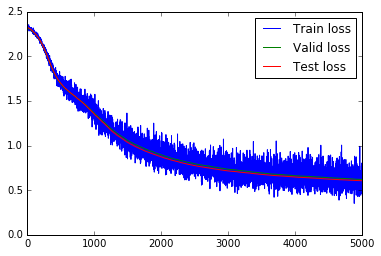

In [19]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

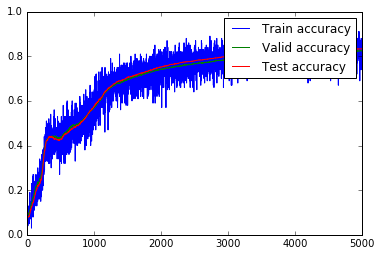

In [20]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()